# Week 2: Diving deeper into the BBC News archive

Welcome! In this assignment you will be revisiting the [BBC News Classification Dataset](https://www.kaggle.com/c/learn-ai-bbc/overview), which contains 2225 examples of news articles with their respective labels. 

This time you will not only work with the tokenization process, but you will also create a classifier using specialized layers for text data such as Embedding and GlobalAveragePooling1D.

#### TIPS FOR SUCCESSFUL GRADING OF YOUR ASSIGNMENT:

- All cells are frozen except for the ones where you need to submit your solutions or when explicitly mentioned you can interact with it.

- You can add new cells to experiment but these will be omitted by the grader, so don't rely on newly created cells to host your solution code, use the provided places for this.

- You can add the comment # grade-up-to-here in any graded cell to signal the grader that it must only evaluate up to that point. This is helpful if you want to check if you are on the right track even if you are not done with the whole assignment. Be sure to remember to delete the comment afterwards!

- Avoid using global variables unless you absolutely have to. The grader tests your code in an isolated environment without running all cells from the top. As a result, global variables may be unavailable when scoring your submission. Global variables that are meant to be used will be defined in UPPERCASE.

- To submit your notebook, save it and then click on the blue submit button at the beginning of the page.

Let's get started!

In [1]:
import io
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
import unittests

For this assignment the data comes from a csv. You can find the file `bbc-text.csv` under the `./data` folder. 
Run the next cell to take a peek into the structure of the data. 

In [3]:
with open("data/bbc-text.csv", 'r') as csvfile:
    print(f"First line (header) looks like this:\n\n{csvfile.readline()}")
    print(f"The second line (first data point) looks like this:\n\n{csvfile.readline()}")

First line (header) looks like this:

category,text

The second line (first data point) looks like this:

tech,tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they

As you can see, each data point is composed of the category of the news article followed by a comma and then the actual text of the article. The comma here is used to delimit columns. 

## Defining useful global variables
Next you will define some global variables that will be used throughout the assignment. Feel free to reference them in the upcoming exercises:

- `VOCAB_SIZE`: The maximum number of words to keep, based on word frequency. Defaults to 1000.
  
- `EMBEDDING_DIM`: Dimension of the dense embedding, will be used in the embedding layer of the model. Defaults to 16.
  
- `MAX_LENGTH`: Maximum length of all sequences. Defaults to 120.
  
- `TRAINING_SPLIT`: Proportion of data used for training. Defaults to 0.8
  
**A note about grading:**

**When you submit this assignment for grading these same values for these globals will be used so make sure that all your code works well with these values. After submitting and passing this assignment, you are encouraged to come back here and play with these parameters to see the impact they have in the classification process. Since this next cell is frozen, you will need to copy the contents into a new cell and run it to overwrite the values for these globals.**

In [4]:
VOCAB_SIZE = 1000
EMBEDDING_DIM = 16
MAX_LENGTH = 120
TRAINING_SPLIT = 0.8

## Loading and pre-processing the data

Go ahead and open the data by running the cell below. While there are many ways in which you can do this, this implementation takes advantage of the Numpy function [`loadtxt`](https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html) to load the data. Since the file is saved in a csv format, you need to set the parameter `delimiter=','`, otherwise the function splits at whitespaces by default. Also, you need to set ` dtype='str'` to indicate that the expected content type is a string.

In [5]:
data_dir = "data/bbc-text.csv"
data = np.loadtxt(data_dir, delimiter=',', skiprows=1, dtype='str', comments=None)
print(f"Shape of the data: {data.shape}")
print(f"{data[0]}\n{data[1]}")

Shape of the data: (2225, 2)
['tech'
 'tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv

As expected, you get a Numpy array with shape `(2225, 2)`. This means that you have 2225 rows, and 2 columns. As seen in the output of the previous cell, the first column corresponds to labels, and the second one corresponds to texts. 

In [6]:
# Test the function
print(f"There are {len(data)} sentence-label pairs in the dataset.\n")
print(f"First sentence has {len((data[0,1]).split())} words.\n")
print(f"The first 5 labels are {data[:5,0]}")

There are 2225 sentence-label pairs in the dataset.

First sentence has 737 words.

The first 5 labels are ['tech' 'business' 'sport' 'sport' 'entertainment']


***Expected Output:***

```
There are 2225 sentence-label pairs in the dataset.

First sentence has 737 words.

The first 5 labels are ['tech' 'business' 'sport' 'sport' 'entertainment']
```

## Training - Validation Datasets

### Exercise 1: train_val_datasets
Now you will code the `train_val_datasets` function, which, given the `data` DataFrame, should return the training and validation datasets, consisting of `(text, label)` pairs. For this last part, you will be using the [tf.data.Dataset.from_tensor_slices](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices) method.

In [7]:
# GRADED FUNCTIONS: train_val_datasets
def train_val_datasets(data):
    '''
    Splits data into traning and validations sets
    
    Args:
        data (np.array): array with two columns, first one is the label, the second is the text
    
    Returns:
        (tf.data.Dataset, tf.data.Dataset): tuple containing the train and validation datasets
    '''
    ### START CODE HERE ###

    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = 1780

    # Slice the dataset to get only the texts. Remember that texts are on the second column
    texts = data[:, 1]
    # Slice the dataset to get only the labels. Remember that labels are on the first column
    labels = data[:, 0]
    # Split the sentences and labels into train/validation splits. Write your own code below
    train_texts = texts[0:train_size]
    validation_texts = texts[train_size:]
    train_labels = labels[0:train_size]
    validation_labels = labels[train_size:]
    
    # create the train and validation datasets from the splits
    train_dataset = tf.data.Dataset.from_tensor_slices((train_texts, train_labels))
    validation_dataset = tf.data.Dataset.from_tensor_slices((validation_texts, validation_labels))
    
	### END CODE HERE ### 
    
    return train_dataset, validation_dataset

In [8]:
# Create the datasets
train_dataset, validation_dataset = train_val_datasets(data)

print(f"There are {train_dataset.cardinality()} sentence-label pairs for training.\n")
print(f"There are {validation_dataset.cardinality()} sentence-label pairs for validation.\n")

There are 1780 sentence-label pairs for training.

There are 445 sentence-label pairs for validation.



***Expected Output:***

```
There are 1780 sentence-label pairs for training.

There are 445 sentence-label pairs for validation.
```

In [9]:
# Test your code!
unittests.test_train_val_datasets(train_val_datasets)

 All tests passed!


## Vectorization - Sequences and padding

With your training and validation data it is now time to perform the vectorization. However, first you need an important intermediate step which is to define a standardize function, which will be used to apply a transformation to every entry in your dataset in an attempt to standardize it. In this case you will use a function that removes [stopwords](https://en.wikipedia.org/wiki/Stop_word) from the texts in the dataset. This should improve the performance of your classifier by removing frequently used words that don't add information to determine the topic of the news. The function also removes any punctuation and makes all words lowercase. This function is already provided for you and can be found in the cell below:

In [10]:
def standardize_func(sentence):
    """
    Removes a list of stopwords
    
    Args:
        sentence (tf.string): sentence to remove the stopwords from
    
    Returns:
        sentence (tf.string): lowercase sentence without the stopwords
    """
    # List of stopwords
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "her", "here",  "hers", "herself", "him", "himself", "his", "how",  "i", "if", "in", "into", "is", "it", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she",  "should", "so", "some", "such", "than", "that",  "the", "their", "theirs", "them", "themselves", "then", "there", "these", "they", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we",  "were", "what",  "when", "where", "which", "while", "who", "whom", "why", "why", "with", "would", "you",  "your", "yours", "yourself", "yourselves", "'m",  "'d", "'ll", "'re", "'ve", "'s", "'d"]
 
    # Sentence converted to lowercase-only
    sentence = tf.strings.lower(sentence)
    
    # Remove stopwords
    for word in stopwords:
        if word[0] == "'":
            sentence = tf.strings.regex_replace(sentence, rf"{word}\b", "")
        else:
            sentence = tf.strings.regex_replace(sentence, rf"\b{word}\b", "")
    
    # Remove punctuation
    sentence = tf.strings.regex_replace(sentence, r'[!"#$%&()\*\+,-\./:;<=>?@\[\\\]^_`{|}~\']', "")


    return sentence

Run the cell below to see this standardizing function in action. You can also try with your own sentences:

In [11]:
test_sentence = "Hello! We're just about to see this function in action =)"
standardized_sentence = standardize_func(test_sentence)
print(f"Original sentence is:\n{test_sentence}\n\nAfter standardizing:\n{standardized_sentence}")

Original sentence is:
Hello! We're just about to see this function in action =)

After standardizing:
b'hello  just   see  function  action '


### Exercise 2: fit_vectorizer

Next complete the `fit_vectorizer` function below. This function should return a [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer that has already been fitted on the training sentences. The vocabulary learned by the vectorizer should have `VOCAB_SIZE` size, and truncate the output sequences to have `MAX_LENGTH` length.  

Remember to use the custom function `standardize_func` to standardize each sentence in the vectorizer. You can do this by passing the function to the `standardize` parameter of `TextVectorization`. You are encouraged to take a look into the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) to get a better understanding of how this works. 

In [12]:
# GRADED FUNCTION: fit_vectorizer
def fit_vectorizer(train_sentences, standardize_func):
    '''
    Defines and adapts the text vectorizer

    Args:
        train_sentences (tf.data.Dataset): sentences from the train dataset to fit the TextVectorization layer
        standardize_func (FunctionType): function to remove stopwords and punctuation, and lowercase texts.
    Returns:
        TextVectorization: adapted instance of TextVectorization layer
    '''
    ### START CODE HERE ###
    
    # Instantiate the TextVectorization class, passing in the correct values for the given parameters below
    vectorizer = tf.keras.layers.TextVectorization( 
		standardize = standardize_func,
		max_tokens = VOCAB_SIZE,
		output_sequence_length = MAX_LENGTH
	) 
    
    # Adapt the vectorizer to the training sentences
    vectorizer.adapt(train_sentences)
	
    ### END CODE HERE ###
    
    return vectorizer

In [13]:
# Create the vectorizer
text_only_dataset = train_dataset.map(lambda text, label: text)
vectorizer = fit_vectorizer(text_only_dataset, standardize_func)
vocab_size = vectorizer.vocabulary_size()

print(f"Vocabulary contains {vocab_size} words\n")

Vocabulary contains 1000 words



***Expected Output:***

```
Vocabulary contains 1000 words
```

In [14]:
# Test your code!
unittests.test_fit_vectorizer(fit_vectorizer, standardize_func)

 All tests passed!


### Exercise 3: fit_label_encoder

Remember your categories are also text labels, so you need to encode the labels as well. For this complete the `tokenize_labels` function below.

A couple of things to note:
- Use the function [`tf.keras.layers.StringLookup`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup) to encode the labels. Use the correct parameters so that you don't include any OOV tokens.
- You should fit the tokenizer to all the labels to avoid the case of a particular label not being present in the validation set. Since you are dealing with labels there should never be an OOV label. For this, you can concatenate the two datasets using the [`concatenate`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#concatenate) method from `tf.data.Dataset` objects.


In [15]:
# GRADED FUNCTION: fit_label_encoder
def fit_label_encoder(train_labels, validation_labels):
    """Creates an instance of a StringLookup, and trains it on all labels

    Args:
        train_labels (tf.data.Dataset): dataset of train labels
        validation_labels (tf.data.Dataset): dataset of validation labels

    Returns:
        tf.keras.layers.StringLookup: adapted encoder for train and validation labels
    """
    ### START CODE HERE ###
    
    # join the two label datasets
    labels =  train_labels.concatenate(validation_labels) #concatenate the two datasets.
    
    # Instantiate the StringLookup layer. Remember that you don't want any OOV tokens
    label_encoder = tf.keras.layers.StringLookup(num_oov_indices = 0)
    
    # Fit the TextVectorization layer on the train_labels
    label_encoder.adapt(labels)
   
    ### END CODE HERE ###
    
    return label_encoder

Use your function to create a trained instance of the encoder, and print the obtained vocabulary to check that there are no OOV tokens.

In [16]:
# Create the label encoder
train_labels_only = train_dataset.map(lambda text, label: label)
validation_labels_only = validation_dataset.map(lambda text, label: label)

label_encoder = fit_label_encoder(train_labels_only,validation_labels_only)
                                  
print(f'Unique labels: {label_encoder.get_vocabulary()}')

Unique labels: ['sport', 'business', 'politics', 'tech', 'entertainment']


***Expected Output:***

```
Unique labels: ['sport', 'business', 'politics', 'tech', 'entertainment']
```

In [17]:
# Test your code!
unittests.test_fit_label_encoder(fit_label_encoder)

 All tests passed!


### Exercise 4: preprocess_dataset

Now that you have trained the vectorizer for the texts and the encoder for the labels, it's time for you to actually transform the dataset. For this complete the `preprocess_dataset` function below. 
Use this function to set the dataset batch size to 32

Hint:
- You can apply the preprocessing to each pair or text and label by using the [`.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) method.
- You can set the batchsize to any Dataset by using the [`.batch`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) method.

In [18]:
# GRADED FUNCTION: preprocess_dataset
def preprocess_dataset(dataset, text_vectorizer, label_encoder):
    """Apply the preprocessing to a dataset

    Args:
        dataset (tf.data.Dataset): dataset to preprocess
        text_vectorizer (tf.keras.layers.TextVectorization ): text vectorizer
        label_encoder (tf.keras.layers.StringLookup): label encoder

    Returns:
        tf.data.Dataset: transformed dataset
    """
    
    ### START CODE HERE ###

    # Convert the Dataset sentences to sequences, and encode the text labels
    text_only_dataset = dataset.map(lambda text, label: text)
    label_only_dataset = dataset.map(lambda text, label: label)
    
    text_transformed_dataset = text_only_dataset.map(lambda text: text_vectorizer(text))
    label_transformed_dataset = label_only_dataset.map(lambda label: label_encoder(label))
    
    dataset = tf.data.Dataset.zip(text_transformed_dataset, label_transformed_dataset)
    
    dataset = (dataset
                .cache()
                .shuffle(10000)
                .prefetch(tf.data.AUTOTUNE)
                .batch(32)
              ) # Set a batchsize of 32
    
	### END CODE HERE ###
    
    return dataset

In [19]:
# Preprocess your dataset
train_proc_dataset = preprocess_dataset(train_dataset, vectorizer, label_encoder)
validation_proc_dataset = preprocess_dataset(validation_dataset, vectorizer, label_encoder)

print(f"Number of batches in the train dataset: {train_proc_dataset.cardinality()}")
print(f"Number of batches in the validation dataset: {validation_proc_dataset.cardinality()}")

Number of batches in the train dataset: 56
Number of batches in the validation dataset: 14


***Expected Output:***

```
Number of batches in the train dataset: 56
Number of batches in the validation dataset: 14
```

In [20]:
train_batch = next(train_proc_dataset.as_numpy_iterator())
validation_batch = next(validation_proc_dataset.as_numpy_iterator())

print(f"Shape of the train batch: {train_batch[0].shape}")
print(f"Shape of the validation batch: {validation_batch[0].shape}")

Shape of the train batch: (32, 120)
Shape of the validation batch: (32, 120)


Expected output:

```
Shape of the train batch: (32, 120)
Shape of the validation batch: (32, 120)
```


In [21]:
# Test your code!
unittests.test_preprocess_dataset(preprocess_dataset, vectorizer, label_encoder)

 All tests passed!


## Selecting the model for text classification
### Exercise 5: create_model
Now that the data is ready to be fed into a Neural Network it is time for you to define the model that will classify each text as being part of a certain category. 

For this complete the `create_model` below. 

A couple of things to keep in mind:

- The last layer should be a Dense layer with 5 units (since there are 5 categories) with a softmax activation.


- You should also compile your model using an appropriate loss function and optimizer.


- You can use any architecture you want but keep in mind that this problem doesn't need many layers to be solved successfully. You don't need any layers beside Embedding, [GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) and Dense layers but feel free to try out different architectures.

- **To pass this graded function your model should reach at least a 95% training accuracy and a 90% validation accuracy in under 30 epochs.**

In [22]:
# GRADED FUNCTION: create_model
def create_model():
    """
    Creates a text classifier model
    Returns:
      tf.keras Model: the text classifier model
    """
   
    ### START CODE HERE ###
	
    # Define your model
    model = tf.keras.Sequential([ 
        tf.keras.Input(shape = (MAX_LENGTH,)),
        tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(24, activation = 'relu'),
        tf.keras.layers.Dense(5, activation = 'softmax')
    ])
    
    # Compile model. Set an appropriate loss, optimizer and metrics
    model.compile(
		loss = 'sparse_categorical_crossentropy',
		optimizer = 'adam',
		metrics = ['accuracy'] 
	) 

    ### END CODE HERE ###

    return model

The next cell allows you to check the number of total and trainable parameters of your model and prompts a warning in case these exceeds those of a reference solution, this serves the following 3 purposes listed in order of priority:

- Helps you prevent crashing the kernel during training.

- Helps you avoid longer-than-necessary training times.
- Provides a reasonable estimate of the size of your model. In general you will usually prefer smaller models given that they accomplish their goal successfully.


**Notice that this is just informative** and may be very well below the actual limit for size of the model necessary to crash the kernel. So even if you exceed this reference you are probably fine. However, **if the kernel crashes during training or it is taking a very long time and your model is larger than the reference, come back here and try to get the number of parameters closer to the reference.**

In [23]:
# Get the untrained model
model = create_model()

# Check the parameter count against a reference solution
unittests.parameter_count(model)

Your model has 16,533 total parameters and the reference is 20,000. You are good to go!

Your model has 16,533 trainable parameters and the reference is 20,000. You are good to go!


In [24]:
example_batch = train_proc_dataset.take(1)

try:
	model.evaluate(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (32, 5)


**Expected output:**
```
predictions have shape: (32, 5)
```

In [25]:
# Test your code!
unittests.test_create_model(create_model)

 All tests passed!


In [26]:
history = model.fit(train_proc_dataset, epochs=30, validation_data=validation_proc_dataset)

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3120 - loss: 1.6013 - val_accuracy: 0.5596 - val_loss: 1.5621
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6337 - loss: 1.5376 - val_accuracy: 0.6180 - val_loss: 1.4502
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6650 - loss: 1.3982 - val_accuracy: 0.6989 - val_loss: 1.2576
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7238 - loss: 1.1766 - val_accuracy: 0.7461 - val_loss: 1.0251
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7906 - loss: 0.9268 - val_accuracy: 0.8764 - val_loss: 0.8132
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9158 - loss: 0.6922 - val_accuracy: 0.9101 - val_loss: 0.6484
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9445 - loss: 0.5364 - val_accuracy: 0.9258 - val_loss: 0.5065
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9500 - loss: 0.4211 - val_accuracy: 0.9371 - val_loss:

Once training has finished you can run the following cell to check the training and validation accuracy achieved at the end of each epoch.

**Remember that to pass this assignment your model should achieve a training accuracy of at least 95% and a validation accuracy of at least 90%. If your model didn't achieve these thresholds, try training again with a different model architecture.**

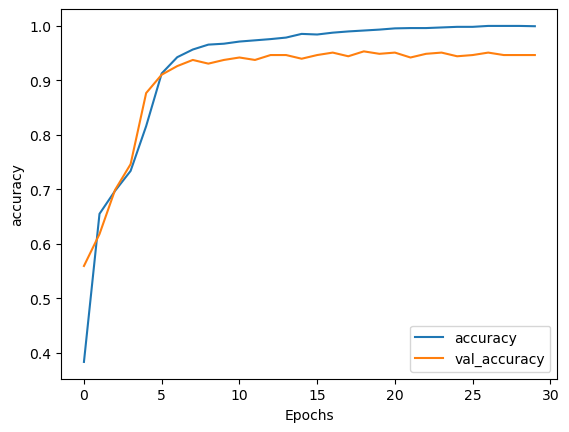

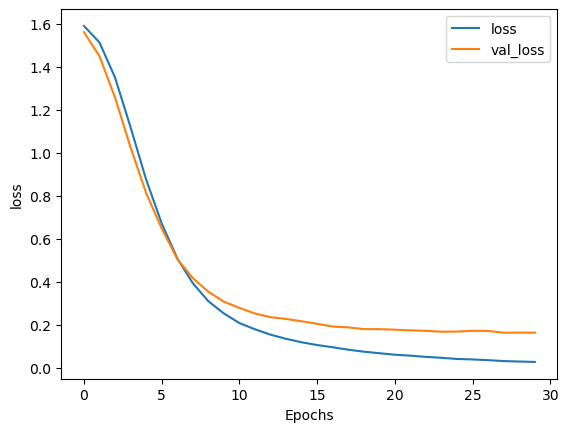

In [27]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

If your model passes the previously mentioned thresholds, and you are happy with the results, be sure to save your notebook and submit it for grading. Also run the cell below to save the history of the model. This is needed for grading purposes

In [28]:
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

## Optional Exercise - Visualizing 3D Vectors

As you saw on the lecture you can visualize the vectors associated with each word in the training set in a 3D space.

For this run the following cell, which will create the `metadata.tsv` and `weights.tsv` files. These are the ones you are going to upload to[Tensorflow's Embedding Projector](https://projector.tensorflow.org/).

In [29]:
embedding = model.layers[0]

with open('./metadata.tsv', "w") as f:
    for word in vectorizer.get_vocabulary():
        f.write("{}\n".format(word))
weights = tf.Variable(embedding.get_weights()[0][1:])

with open('./weights.tsv', 'w') as f: 
    for w in weights:
        f.write('\t'.join([str(x) for x in w.numpy()]) + "\n")

By running the previous cell, these files are placed within your filesystem. To download them, right click on the file, which you will see on the left sidebar, and select the `Download` option. 

**Congratulations on finishing this week's assignment!**

You have successfully implemented a neural network capable of classifying text and also learned about embeddings and tokenization along the way!

**Keep it up!**